## What's Cooking? Kaggle comp and CDA final project 

#### Description
Picture yourself strolling through your local, open-air market... What do you see? What do you smell? What will you make for dinner tonight?

If you're in Northern California, you'll be walking past the inevitable bushels of leafy greens, spiked with dark purple kale and the bright pinks and yellows of chard. Across the world in South Korea, mounds of bright red kimchi greet you, while the smell of the sea draws your attention to squids squirming nearby. India’s market is perhaps the most colorful, awash in the rich hues and aromas of dozens of spices: turmeric, star anise, poppy seeds, and garam masala as far as the eye can see.

Some of our strongest geographic and cultural associations are tied to a region's local foods. This playground competitions asks you to predict the category of a dish's cuisine given a list of its ingredients. 

Acknowledgements: 
We want to thank Yummly for providing this unique dataset. Kaggle is hosting this playground competition for fun and practice.

#### The dataset
In the dataset, we include the recipe id, the type of cuisine, and the list of ingredients of each recipe (of variable length). The data is stored in JSON format. 

In [87]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [88]:
train = pd.read_json('train.json')

In [89]:
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


This is a 'simple' dataset. We have the label (cuisine), the recipe id (which is for Yummly labelling and offers no real insight into the subject matter), and we have the list of ingredients. 

The focus of this study is on the list of ingredents. We will explore questions including:
* Do some cuisines use more ingredients than others?
* Which cuisines are the most similar? Most different?
* Which ingredients are commonly used across all cuisines?
* Which ingredients provide the best indicator of a recipe's cuisine?

And, of course, we will apply Machine Learning techniques to build a prediction engine that can determine the cuisine of a food based on a list of ingredients.

# EDA

To begin with, we did some basic exploring. We can see that we have about 40,000 recipes in our dataset. 

In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 4 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
number         39774 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.2+ MB


There are 20 cuisines. In the below summary we can see that Italian cuisine is 'over-represented' in this dataset, followed closely by Mexican and Southern_US. The dataset is, thus, unbalanced. We will come back to this before we begin ML. For now, it is interesting context for us. 

In [91]:
print(train['cuisine'].value_counts())
print(train['cuisine'].nunique())

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64
20


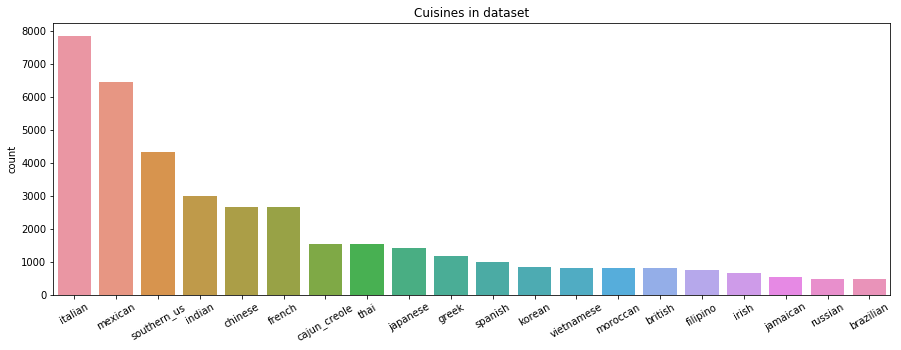

In [92]:
plt.figure(figsize = (15,5))
ax = sns.countplot(train['cuisine'], order = train['cuisine'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('Cuisines in dataset')
ax.set_xlabel('');

We created a 'number of ingredients' feature, ie. how many ingredients appear in each recipe. We hypothesise that this may be a contributing factor when predicting cuisine.

Key insights from this section: 
* The most complex recipe has 65 ingredients, while the simplest has only 1.
* We can see that, on average, the cuisines with the most ingredients are Moroccan (13), Indian (12), Vietanmese (12), Cajun (12) and Thai (12).

In [93]:
train['number'] = [len(i) for i in train['ingredients']]
train.head()

,cuisine,id,ingredients,number
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20


In [95]:
train['number'].median()
train.groupby('cuisine')['number'].median()

cuisine
brazilian        9
british          9
cajun_creole    12
chinese         12
filipino        10
french           9
greek           10
indian          12
irish            9
italian         10
jamaican        12
japanese         9
korean          11
mexican         10
moroccan        13
russian         10
southern_us      9
spanish         10
thai            12
vietnamese      12
Name: number, dtype: int64

In [108]:
result = train.groupby(["cuisine"])['number'].mean().reset_index().sort_values('number', ascending = False)

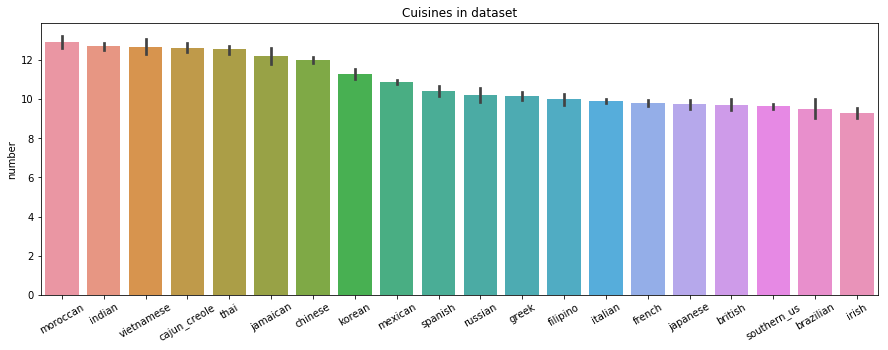

In [109]:
plt.figure(figsize = (15,5))
ax = sns.barplot(x = 'cuisine', y = 'number', data = train, order = result['cuisine'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('Cuisines in dataset')
ax.set_xlabel('');


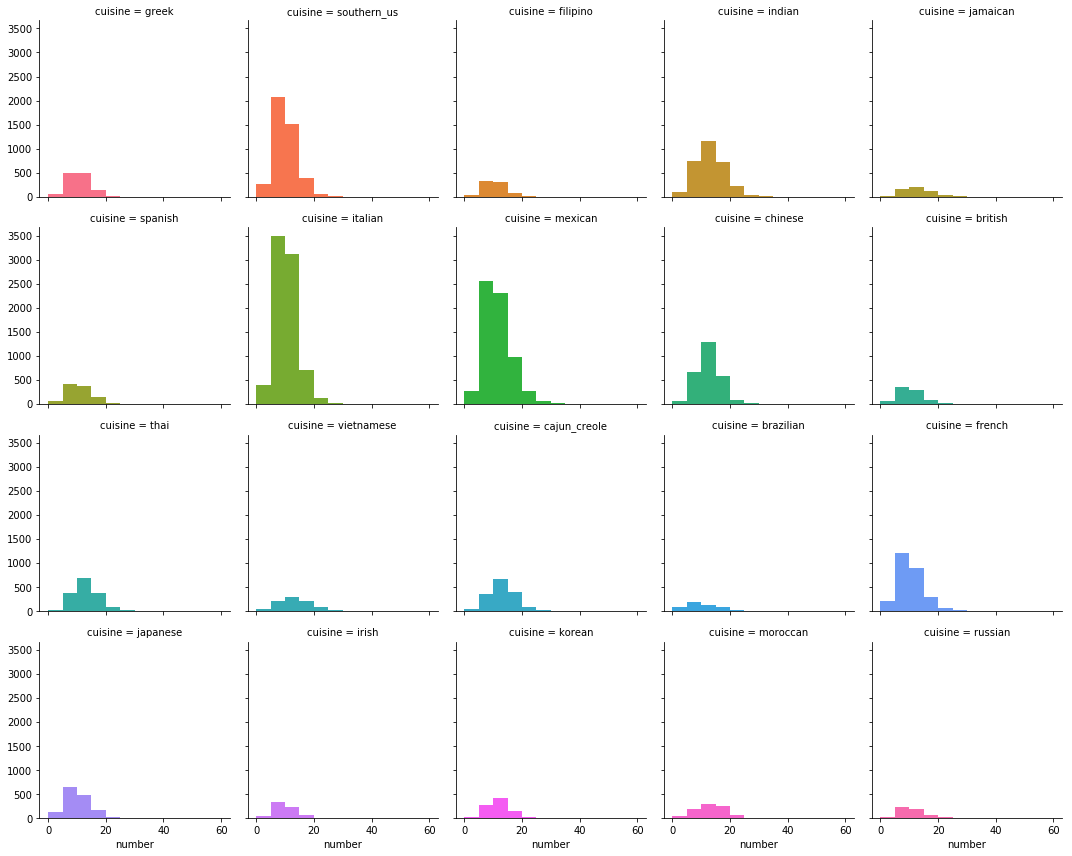

In [112]:
# can we normalize the below to improve cross-cuisine comparison?

g = sns.FacetGrid(train, col = "cuisine", col_wrap = 5, margin_titles=True, hue = 'cuisine')
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "number", bins=bins);
#plt.axvline('number_ingredients'.mean(), color='k', linestyle='dashed', linewidth=1);

In [135]:
print('Maximum Number of Ingredients in a Dish: ',train['number'].max())
print('Minimum Number of Ingredients in a Dish: ',train['number'].min())

Maximum Number of Ingredients in a Dish:  65
Minimum Number of Ingredients in a Dish:  2


In [136]:
print("Explore the ingredients in the longest recipe in our training set:" + "\n")
print(str(list(longrecipes[longrecipes['ingredients'].str.len() == 65].ingredients.values)) + "\n")
print("Cuisine: " + str(list(longrecipes[longrecipes['ingredients'].str.len() == 65].cuisine)))

Explore the ingredients in the longest recipe in our training set:



NameError: name 'longrecipes' is not defined

We have 215 recipes with only 1 ingredient. This does not make sense given the context of our study, and will mislead the algorithm to over-value these ingredients. We therefore discard these rows. 

In [123]:
train[train['number'] < 2]

,cuisine,id,ingredients,number
940,japanese,4734,[sushi rice],1
2088,vietnamese,7833,[dried rice noodles],1
6787,indian,36818,[plain low-fat yogurt],1
7011,indian,19772,[unsalted butter],1
8181,japanese,16116,[udon],1
8852,thai,29738,[sticky rice],1
8990,indian,41124,[butter],1
10506,mexican,32631,[corn tortillas],1
13178,thai,29570,[grained],1
17804,southern_us,29849,[lemonade concentrate],1


In [127]:
train = train[train['number'] > 1]
train.shape

(39752, 4)

Now we begin to look at the counts of different ingredients to understand which are most commonly used.

In [ ]:
# can we instead do this by creating a column in the df? 

In [128]:
allingredients = [] # this list stores all the ingredients in all recipes (with duplicates)
for item in train['ingredients']:
    for ingr in item:
        allingredients.append(ingr) 

In [154]:
ingredients_df = pd.DataFrame(allingredients, columns=['ingredient'])

In [164]:
ingredients_df = ingredients_df.groupby('ingredient')['ingredient'].count().reset_index(name="count")

In [172]:
print("The most commonly used ingredients (with counts) are:")
print("\n")
print(ingredients_df.nlargest(20, 'count'))
print("\n")
print("The number of unique ingredients in our training sample is {}.".format(len(countingr)))

The most commonly used ingredients (with counts) are:


               ingredient  count
5309                 salt  18049
4343            olive oil   7972
4361               onions   7972
6435                water   7456
2884               garlic   7380
5888                sugar   6434
2890        garlic cloves   6237
1220               butter   4846
3135  ground black pepper   4785
555     all-purpose flour   4632
4569               pepper   4438
6375        vegetable oil   4384
2436                 eggs   3388
5744            soy sauce   3296
3591          kosher salt   3113
3102         green onions   3078
6146             tomatoes   3058
3641           large eggs   2948
1386              carrots   2814
6268      unsalted butter   2779


The number of unique ingredients in our training sample is 6714.


In [174]:
# let's plot these 

In [175]:
# let's see which cuisines have the greatest range of ingredients  

# ML

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [14]:
# combine lists into single list for tokenization

train['ingredients'] = [' '.join(inner_list) for inner_list in train['ingredients']]

In [15]:
# create the transform
vectorizer = CountVectorizer()

In [16]:
# tokenize and build vocab
vectorizer.fit(train['ingredients'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
# summarize
print(vectorizer.vocabulary_)
print(len(vectorizer.vocabulary_))

{'romaine': 2295, 'lettuce': 1527, 'black': 247, 'olives': 1868, 'grape': 1169, 'tomatoes': 2770, 'garlic': 1094, 'pepper': 1998, 'purple': 2181, 'onion': 1872, 'seasoning': 2403, 'garbanzo': 1088, 'beans': 184, 'feta': 958, 'cheese': 522, 'crumbles': 738, 'plain': 2080, 'flour': 1013, 'ground': 1204, 'salt': 2349, 'thyme': 2747, 'eggs': 898, 'green': 1190, 'yellow': 2983, 'corn': 676, 'meal': 1666, 'milk': 1707, 'vegetable': 2877, 'oil': 1860, 'mayonaise': 1660, 'cooking': 671, 'chilies': 550, 'grilled': 1197, 'chicken': 536, 'breasts': 330, 'powder': 2133, 'soy': 2545, 'sauce': 2374, 'butter': 375, 'livers': 1553, 'water': 2922, 'wheat': 2933, 'shallots': 2428, 'cornflour': 681, 'cayenne': 488, 'onions': 1873, 'paste': 1961, 'lemon': 1518, 'juice': 1386, 'chili': 549, 'passata': 1957, 'cumin': 763, 'boneless': 283, 'skinless': 2491, 'thigh': 2739, 'garam': 1087, 'masala': 1645, 'double': 849, 'cream': 708, 'natural': 1799, 'yogurt': 2987, 'bay': 180, 'leaf': 1505, 'sugar': 2647, 'fre

In [19]:
# encode document
vector = vectorizer.transform(train['ingredients'])

In [20]:
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

(39774, 3010)
<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [21]:
from sklearn.preprocessing import OneHotEncoder
import itertools

In [22]:
r = pd.SparseDataFrame(vectorizer.fit_transform(train['ingredients']), 
                       train.index,
                       vectorizer.get_feature_names(), 
                       default_fill_value=0)

In [23]:
r.head()

,00,10,100,14,15,25,33,40,43,95,...,za,zatarain,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini,épices
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
print(type(r))
print(r.info())

<class 'pandas.core.sparse.frame.SparseDataFrame'>
<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Columns: 3010 entries, 00 to épices
dtypes: int64(3010)
memory usage: 5.8 MB
None


In [32]:
train.join(r, lsuffix='_left', rsuffix='_right')

,cuisine_left,id,ingredients,number,00,10,100,14,15,25,...,za,zatarain,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini,épices
0,greek,10259,romaine lettuce black olives grape tomatoes ga...,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,southern_us,25693,plain flour ground pepper salt tomatoes ground...,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,filipino,20130,eggs pepper salt mayonaise cooking oil green c...,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,indian,22213,water vegetable oil wheat salt,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,indian,13162,black pepper shallots cornflour cayenne pepper...,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,jamaican,6602,plain flour sugar butter eggs fresh ginger roo...,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,spanish,42779,olive oil salt medium shrimp pepper garlic cho...,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,italian,3735,sugar pistachio nuts white almond bark flour v...,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,mexican,16903,olive oil purple onion fresh pineapple pork po...,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,italian,12734,chopped tomatoes fresh basil garlic extra-virg...,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(r)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

* look at posterior and prior probabilities
* look at top ingredients by cuisine
* look at idf (which ingredients are the most decisive)


* Logistic Regression
* Random Forest
* Naive Bayes
* SVC